<a href="https://colab.research.google.com/github/Kravty/MachineLearning/blob/main/PyTorch_Spam_Detection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> The notebook contains the RNN (Recurrent Neural Network), specifically LSTM (Long Short-Term Memory) model used of Kaggle dataset 'SMS Spam Collection Dataset' for text classification.

<h4> Import of libraries

In [1]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
import itertools

<h4> Data preparation

In [2]:
# Encoding has to be specified to work with the file
df = pd.read_csv('https://raw.githubusercontent.com/Kravty/MachineLearning/main/Datasets/spam.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Dropping unnecessary columns and renaming remaining columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ['Labels', 'Data']
df.head()

,Labels,Data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Creating binary labels
df['BinaryLabels'] = df['Labels'].map({'ham': 0, 'spam': 1})
df.head()

,Labels,Data,BinaryLabels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
# Creating dataframe with binary labels and data (for the purpose of model training)
df2 = df[['Data', 'BinaryLabels']]
df2.head()

,Data,BinaryLabels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
# Saving dataframe with BinaryLabels to csv file (without index column)
df2.to_csv('spam2.csv', index=False)

In [8]:
# Creating field objects

# Input field object
# Padding is set to pre-padding because of RNN (LSTM) gradient vanishing problem 
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    tokenize='spacy',
    pad_first=True)

# Creating target field object
LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

In [9]:
# Creating tabular dataset object (based on new csv file)
dataset = ttd.TabularDataset(
    path='spam2.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [10]:
# Spliting train and validation set
train_dataset, test_dataset = dataset.split(0.8)

In [11]:
# Creating vocab on TEXT field of the train set
TEXT.build_vocab(train_dataset,)
vocab = TEXT.vocab

In [12]:
# Printing all tokens and vocabulary with their indexes
vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'<unk>': 0,
             '<pad>': 1,
             '.': 2,
             'to': 3,
             'I': 4,
             ',': 5,
             'you': 6,
             '?': 7,
             'a': 8,
             '!': 9,
             'the': 10,
             '...': 11,
             'i': 12,
             'and': 13,
             'in': 14,
             'is': 15,
             'me': 16,
             'u': 17,
             '..': 18,
             'for': 19,
             'my': 20,
             'it': 21,
             'of': 22,
             'your': 23,
             '&': 24,
             'that': 25,
             'have': 26,
             'do': 27,
             'on': 28,
             '2': 29,
             ' ': 30,
             "'s": 31,
             ';': 32,
             'call': 33,
             'are': 34,
             ':': 35,
             "'m": 36,
             'be': 37,
             'or': 38,
             'at': 39,
             'now': 40,


In [13]:
# Printing list of tokens
vocab.itos

['<unk>',
 '<pad>',
 '.',
 'to',
 'I',
 ',',
 'you',
 '?',
 'a',
 '!',
 'the',
 '...',
 'i',
 'and',
 'in',
 'is',
 'me',
 'u',
 '..',
 'for',
 'my',
 'it',
 'of',
 'your',
 '&',
 'that',
 'have',
 'do',
 'on',
 '2',
 ' ',
 "'s",
 ';',
 'call',
 'are',
 ':',
 "'m",
 'be',
 'or',
 'at',
 'now',
 "n't",
 'not',
 'with',
 'U',
 'get',
 'will',
 'so',
 'can',
 'nt',
 '4',
 'lt;#&gt',
 '*',
 'but',
 'up',
 'You',
 '-',
 'ur',
 'we',
 ')',
 'out',
 'from',
 'go',
 'just',
 'know',
 'when',
 'this',
 'if',
 '"',
 '/',
 "'ll",
 'was',
 'like',
 'got',
 'all',
 'come',
 'time',
 'am',
 'there',
 'then',
 'No',
 'day',
 'only',
 'Do',
 'by',
 'what',
 'going',
 'he',
 'about',
 'lor',
 'one',
 'want',
 'home',
 'love',
 'Call',
 'How',
 'good',
 'need',
 'send',
 'as',
 'We',
 'how',
 'n',
 'back',
 'no',
 'Ok',
 'still',
 'later',
 'text',
 'If',
 'its',
 '_',
 'did',
 'da',
 'our',
 'But',
 'been',
 'her',
 'd',
 'ok',
 'Just',
 'see',
 'think',
 'So',
 'What',
 'FREE',
 'free',
 'has',
 'here

In [14]:
print(f'Number of tokens: {len(vocab.itos)}')

Number of tokens: 10254


In [15]:
# Creating device object
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
# Creating data iterators
# sort_key is set in a way that created batches will be of similar length of data
# This will result in more efective padding (long sentenced are grouped together)
train_iter, test_iter = ttd.Iterator.splits(
        (train_dataset, test_dataset), sort_key=lambda x: len(x.data),
        batch_sizes=(32, 256), device=device)

<h4> Building the model 

In [17]:
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # Initializing hidden (LSTM) states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # Turning word indexes into word vectors
    out = self.embed(X) # Output has shape n_samples x sequence length x D

    # Passing the data to LSTM layer
    out, _ = self.rnn(out, (h0, c0)) # Output has shape n_samples x sequence length x M

    # Max pooling
    out, _ = torch.max(out, 1) # Output is n_samples x M

    # Passing the data to Dense layer
    out = self.fc(out) # Output is n_samples x K
    return out

In [18]:
# Instantiating the model and moving parameters to the GPU
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(10254, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [19]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

<h4> Training the model

In [20]:
# Training loop function
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    # Variable for storing train losses
    train_loss = []
    for inputs, targets in train_iter:
      # Reshaping targets
      targets = targets.view(-1, 1).float()
      
      # Moving the data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Zero the gradients accumulated by PyTorch
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      # Appending the loss to list of losses per iteration/batch
      train_loss.append(loss.item())

    # Taking mean value of previous losses as loss per epoch
    train_loss = np.mean(train_loss)
    
    
    # Variable for storing test losses
    test_loss = []
    for inputs, targets in test_iter:
      # Reshaping targets
      targets = targets.view(-1, 1).float()

      # Moving the data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Appending the loss to list of losses per iteration/batch
      test_loss.append(loss.item())

    # Taking mean value of previous losses as loss per epoch
    test_loss = np.mean(test_loss)

    # Saving losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [21]:
# Calling training function
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_iter, test_iter, 25)

Epoch 1/25, Train Loss: 0.5463,       Test Loss: 0.4249, Duration: 0:00:00.723898
Epoch 2/25, Train Loss: 0.3516,       Test Loss: 0.3591, Duration: 0:00:00.699627
Epoch 3/25, Train Loss: 0.2627,       Test Loss: 0.2742, Duration: 0:00:00.709709
Epoch 4/25, Train Loss: 0.1806,       Test Loss: 0.2191, Duration: 0:00:00.703583
Epoch 5/25, Train Loss: 0.1284,       Test Loss: 0.1791, Duration: 0:00:00.698019
Epoch 6/25, Train Loss: 0.0973,       Test Loss: 0.1639, Duration: 0:00:00.694931
Epoch 7/25, Train Loss: 0.0789,       Test Loss: 0.1680, Duration: 0:00:00.695612
Epoch 8/25, Train Loss: 0.0638,       Test Loss: 0.1516, Duration: 0:00:00.699393
Epoch 9/25, Train Loss: 0.0542,       Test Loss: 0.1481, Duration: 0:00:00.687087
Epoch 10/25, Train Loss: 0.0459,       Test Loss: 0.1472, Duration: 0:00:00.696326
Epoch 11/25, Train Loss: 0.0406,       Test Loss: 0.1449, Duration: 0:00:00.693587
Epoch 12/25, Train Loss: 0.0370,       Test Loss: 0.1421, Duration: 0:00:00.690872
Epoch 13/25, 

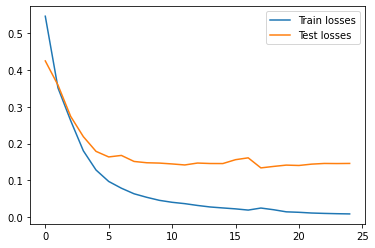

In [22]:
plt.plot(train_losses, label='Train losses')
plt.plot(test_losses, label='Test losses')
plt.legend()
plt.show();

In [23]:
# Calculating accuracy

# Train accuracy
p_train = []
y_train = []
for inputs, targets in train_iter:
  # Reshaping targets
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Getting prediction
  predictions = list((outputs > 0).cpu().numpy())
  
  # Updating variables
  p_train += predictions
  y_train += list(targets.cpu().numpy())

p_train = np.array(p_train)
y_train = np.array(y_train)
train_acc = np.mean(y_train == p_train)


# Test accuracy
p_test = []
y_test = []
for inputs, targets in test_iter:
  # Reshaping targets
  targets = targets.view(-1, 1).float()

  # Forward pass
  outputs = model(inputs)

  # Getting prediction
  predictions = list((outputs > 0).cpu().numpy())
  
  # Updating variables
  p_test += predictions
  y_test += list(targets.cpu().numpy())

p_test = np.array(p_test)
y_test = np.array(y_test)
test_acc = np.mean(y_test == p_test)

print(f"Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9978, Test accuracy: 0.9659


In [24]:
# Confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Plot for train set
Confusion matrix, without normalization


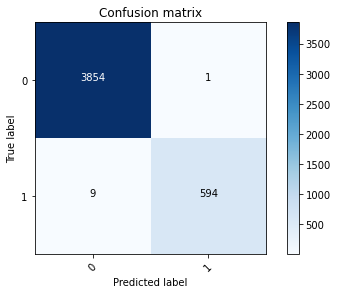

In [25]:
# Plotting confusion matrix for train set
print('Plot for train set')
cm = confusion_matrix(y_train, p_train)
plot_confusion_matrix(cm, [0, 1])

Plot for test set
Confusion matrix, without normalization


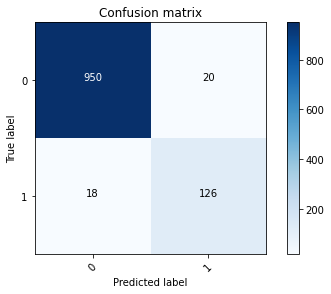

In [26]:
# Plotting confusion matrix for test set
print('Plot for test set')
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, [0, 1])